---
title: Exploring Data
format:
  html:
    css: h1
    embed-resources: true
    code-fold: true
---

## EDA Goals:
The goals of this tab is to gain a deeper understanding of the data, how variables behave, and identify anomalies, paterns, or potential insights for future exploration.

## 


## Vehicle Production by countries
Here, we will be exploring the vehicle_production_countries data set.

In [ ]:
library(tidyverse)
library(ggplot2)
library(boot)
library(AICcmodavg)
library(readxl)
library(broom)

vehicle_production_countries_comercial <- read_excel("../../data/Raw_Data_project_Pub.Transport_5000/vehicle_production_countries.xlsx", sheet="Comercial-vehicles", skip = 1)

# Replace "N", "U", and "Z" with NULL in all columns except the first one
vehicle_production_countries_comercial[-1] <- lapply(vehicle_production_countries_comercial[-1], function(x) ifelse(x %in% c("N", "U", "Z"), NA, x))

vehicle_production_countries_comercial <- vehicle_production_countries_comercial %>%
  mutate(across(-1, as.numeric))

colnames(vehicle_production_countries_comercial)[colnames(vehicle_production_countries_comercial) == "...1"] <- "Country"
colnames(vehicle_production_countries_comercial)

# Transpose the data frame
vehicle_production_countries_comercial_transposed <- as.data.frame(t(vehicle_production_countries_comercial))

# Set the first row as the column names
colnames(vehicle_production_countries_comercial_transposed) <- vehicle_production_countries_comercial_transposed[1, ]

# Remove the first row
vehicle_production_countries_comercial_transposed <- vehicle_production_countries_comercial_transposed[-1, ]

# Convert the year columns to numeric
vehicle_production_countries_comercial_transposed[] <- lapply(vehicle_production_countries_comercial_transposed, as.numeric)

vehicle_production_countries_comercial_transposed <- vehicle_production_countries_comercial_transposed[, !colnames(vehicle_production_countries_comercial_transposed) %in% "Total world"]

df <- vehicle_production_countries_comercial_transposed %>% 
  rownames_to_column(var = "Year")

# Replace "(R) 2019" with 2019 and "(R) 2020" with 2020
df <- df %>%
  mutate(Year = ifelse(Year == "(R) 2019", 2019, ifelse(Year == "(R) 2020", 2020, Year)))

Warning message:
"Removed 188 rows containing missing values (geom_point)."


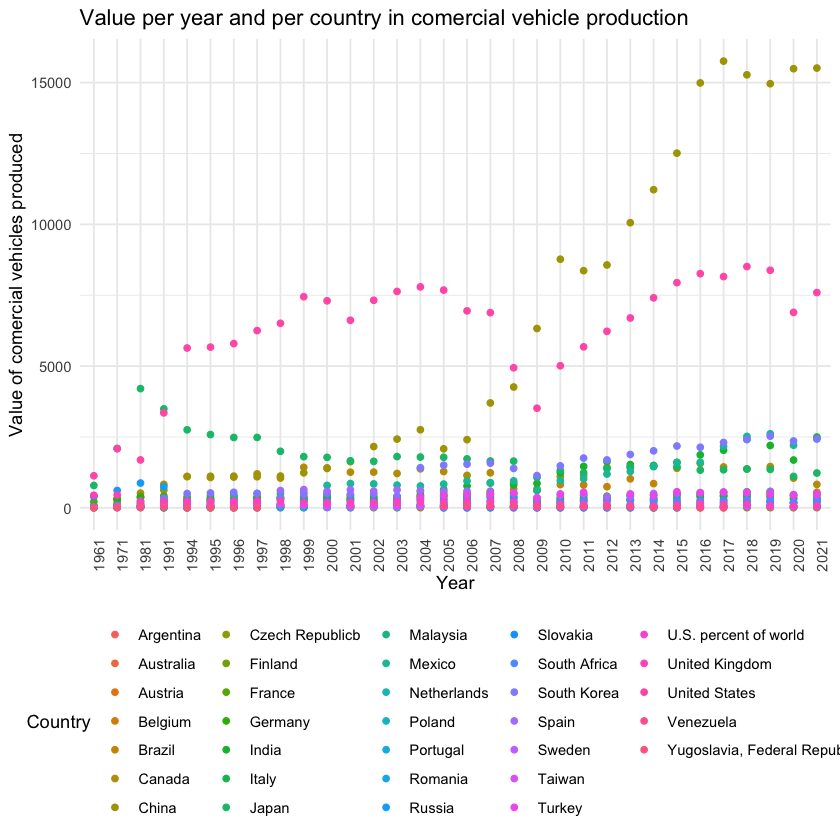

In [161]:
# Pivot the data to long format
df_long <- df %>%
  pivot_longer(-Year, names_to = "Country", values_to = "Value")

# Plotlot
ggplot(df_long, aes(x = Year, y = Value, color = Country)) +
  geom_point() +
  labs(
    title = "Value per year and per country in comercial vehicle production",
    x = "Year",
    y = "Value of comercial vehicles produced"
  ) +
  theme_minimal() +
  theme(legend.position = "bottom", axis.text.x = element_text(angle = 90, hjust = 1))


From this plot we can see how Japan (back in the 1960s) used to be one of the biggest producers but not anymore. The US has been in the lead since the 1990s until around 2008, which was expected due to the recession. However, it is impressive how China was able to excel during the recession in this market at an almost exponential rate. And it still has kept increasing since then. 

In order to run an ANOVA test and look if countries, years, and interaction among the both have an statistical significance on comercial vehicle production, we are going to assume that all the missing values are not relevant to the contribution of the overall market and, therefore, close to 0. Thuis, for the sake of this process, we will make them 0.

In [ ]:
# Replace NA values with 0
vehicle_production_countries_comercial <- replace(vehicle_production_countries_comercial, is.na(vehicle_production_countries_comercial), 0)

In [152]:
data_long <- vehicle_production_countries_comercial %>%
  pivot_longer(cols = -Country, names_to = "Year", values_to = "Value")

data_long <- data_long[data_long$Country != "Total world", ]
# Perform ANOVA
model <- aov(Value ~ Year * Country, data = data_long)

# Summarize the ANOVA results with significance codes
summary_model <- summary(model)

# Print the ANOVA table with significance codes
print(anova(model, test = "F"))



Warning message in anova.lm(object):
"ANOVA F-tests on an essentially perfect fit are unreliable"


Analysis of Variance Table

Response: Value
              Df     Sum Sq  Mean Sq F value Pr(>F)
Year          31   85531235  2759072     NaN    NaN
Country       32 2172668273 67895884     NaN    NaN
Year:Country 992 1139993857  1149187     NaN    NaN
Residuals      0          0      NaN               


Seing this, we will simplify our model, taking away the interaction (in order to no overfit the data with our ANOVA model).

In [486]:
model <- aov(Value ~ Year + Country, data = data_long)

# Summarize the ANOVA results with significance codes
summary_model <- summary(model)

# Print the ANOVA table with significance codes
print(anova(model, test = "F"))

Analysis of Variance Table

Response: Value
           Df     Sum Sq  Mean Sq F value    Pr(>F)    
Year       31   85531235  2759072  2.4009 3.244e-05 ***
Country    32 2172668273 67895884 59.0816 < 2.2e-16 ***
Residuals 992 1139993857  1149187                      
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Both have a significant effect (which was expected). However, this helped us also understand that their interaction would overfit the model in this case.

## Energy and usage of Buses
In this part, we will be exploring the energy_consumed_byMill_passenger_MILES file.

In [ ]:
energy_consum <- read_excel("../../data/Raw_Data_project_Pub.Transport_5000/energy_consumed_byMill_passenger_MILES.xlsx", sheet="Energy")

colnames(energy_consum) <- energy_consum[1, ]

# Remove the first row and the first column
energy_consum <- energy_consum[-1, ]

# Set the first column to "Data_to_Explore"
colnames(energy_consum)[1] <- "Data_to_Explore"

# Filter rows based on specific criteria
energy_consum <- energy_consum[energy_consum$Data_to_Explore %in% c(
  "Vehicle-miles (millions)",
  "Passenger-miles (millions)",
  "Energy consumed, total (billion Btu)",
  "Energy intensity (Btu/passenger-mile)"
), ]

# Replace all "N" values (except in the first column) with NA
energy_consum[, -1] <- apply(energy_consum[, -1], 2, function(x) ifelse(x == "N", NA, x))

# Drop specified columns because of numerous NA
energy_consum <- energy_consum %>% select(-"1960", -"1965", -"1970", -"1975", -"1980", -"1985", -"1990", -"1991", -"1992", -"1993", -"1994", -"1995")

# Change columns from character to numeric (except the first column)
energy_consum <- energy_consum %>%
  mutate_at(vars(-1), as.numeric)

energy_consum_long <-as.data.frame(t(energy_consum), index=False)

colnames(energy_consum_long) <- energy_consum_long[1, ]

# Remove the first row and the first column
energy_consum_long <- energy_consum_long[-1, ]

colnames(energy_consum_long) <- c("Vehicle_milesMill", "Passenger_miles_mill","Energy_consumed_total_bill_Btu", "Energy_intensity_Btu_passenger_mile")

Years = c(1996:2021)
energy_consum_long['Years'] <- Years

# data frame used for the models
energy_consum_long_no_Covid <- energy_consum_long[!(energy_consum_long$Years %in% c(2020, 2021)), ]

For the fitted model in the following plots, year 2020 and 2021 are going to be ignored and considered outliers due to COVID-19. They are heavy outliers.

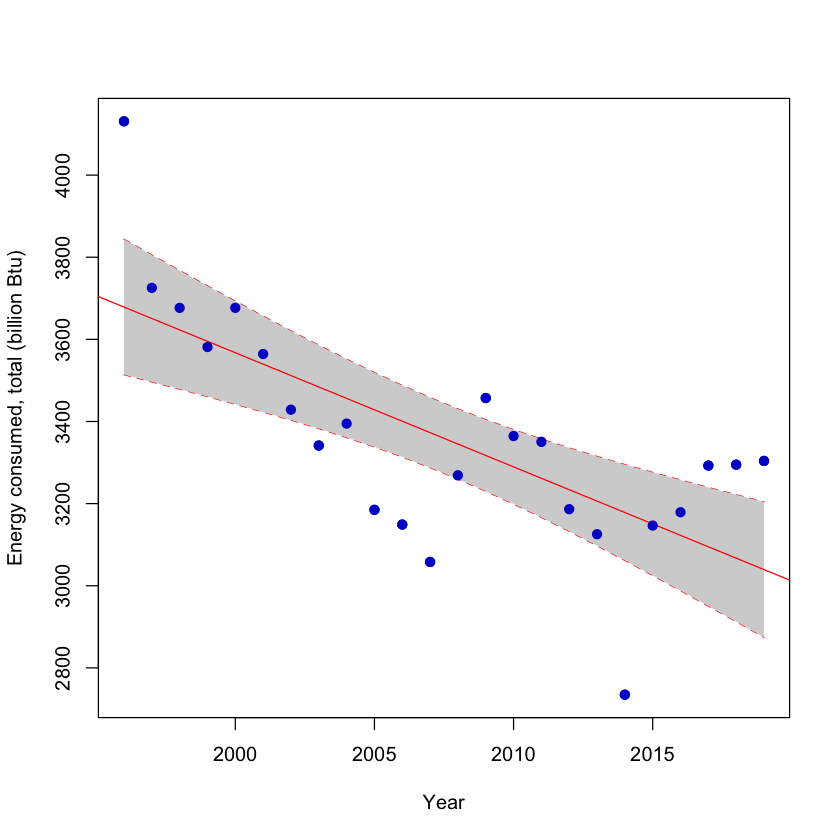

In [19]:
#plot(energy_consum_long$Energy_intensity_Btu_passenger_mile)

# Fit a linear model
lm_model <- lm(energy_consum_long_no_Covid$Energy_intensity_Btu_passenger_mile ~ energy_consum_long_no_Covid$Year)

# Create the plot
plot(energy_consum_long_no_Covid$Year, energy_consum_long_no_Covid$Energy_intensity_Btu_passenger_mile,
     xlab = "Year",
     ylab = "Energy consumed, total (billion Btu)",
     col = "blue3",
     pch = 19)

# Calculate confidence interval
conf_int <- predict(lm_model, interval = "confidence")

# Add confidence interval lines
lines(energy_consum_long_no_Covid$Year, conf_int[, "lwr"], col = "red", lty = 2)
lines(energy_consum_long_no_Covid$Year, conf_int[, "upr"], col = "red", lty = 2)

# Shade the area between confidence interval bounds
polygon(c(energy_consum_long_no_Covid$Year, rev(energy_consum_long_no_Covid$Year)),
        c(conf_int[, "lwr"], rev(conf_int[, "upr"])),
        col = "lightgray", border = NA)

# Add the trend line
abline(lm_model, col = "red")

# Add the points
points(energy_consum_long_no_Covid$Year, energy_consum_long_no_Covid$Energy_intensity_Btu_passenger_mile, col = "blue3", pch = 19)

From this plot we can see how the total energy consumed (in billion Btu) has been constantly decreasing. However, is it because our vehicles are more efficient or due to cuts in public transportation?

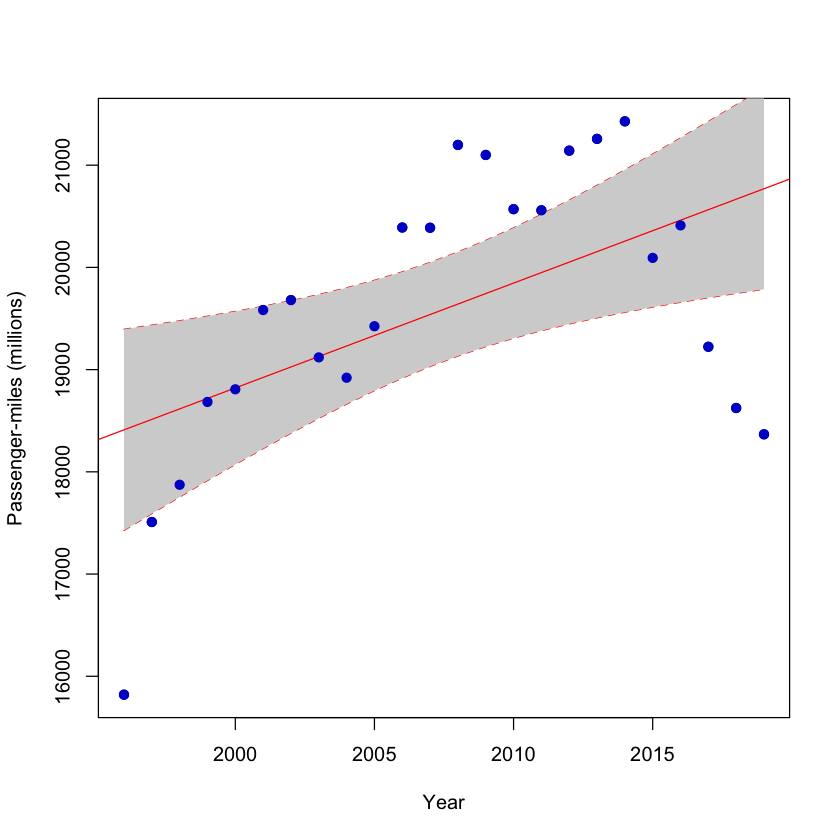

In [21]:
#plot(energy_consum_long$Passenger_miles_mill)

# Fit a linear model
lm_model <- lm(energy_consum_long_no_Covid$Passenger_miles_mill ~ energy_consum_long_no_Covid$Year)

# Create the plot
plot(energy_consum_long_no_Covid$Year, energy_consum_long_no_Covid$Passenger_miles_mill,
     xlab = "Year",
     ylab = "Passenger-miles (millions)",
     col = "blue3",
     pch = 19)

# Calculate confidence interval
conf_int <- predict(lm_model, interval = "confidence")

# Add confidence interval lines
lines(energy_consum_long_no_Covid$Year, conf_int[, "lwr"], col = "red", lty = 2)
lines(energy_consum_long_no_Covid$Year, conf_int[, "upr"], col = "red", lty = 2)

# Shade the area between confidence interval bounds
polygon(c(energy_consum_long_no_Covid$Year, rev(energy_consum_long_no_Covid$Year)),
        c(conf_int[, "lwr"], rev(conf_int[, "upr"])),
        col = "lightgray", border = NA)

# Add the trend line
abline(lm_model, col = "red")

# Add the points
points(energy_consum_long_no_Covid$Year, energy_consum_long_no_Covid$Passenger_miles_mill, col = "blue3", pch = 19)

While the fitted model shows an increase in the usage of public transportation, we can see that it has been constantly dropping since around 2014. This can bring up many questions such as: Is it due to an investment problem? Is it because there are not enough incentives to use public transportation? Do people own more cars?

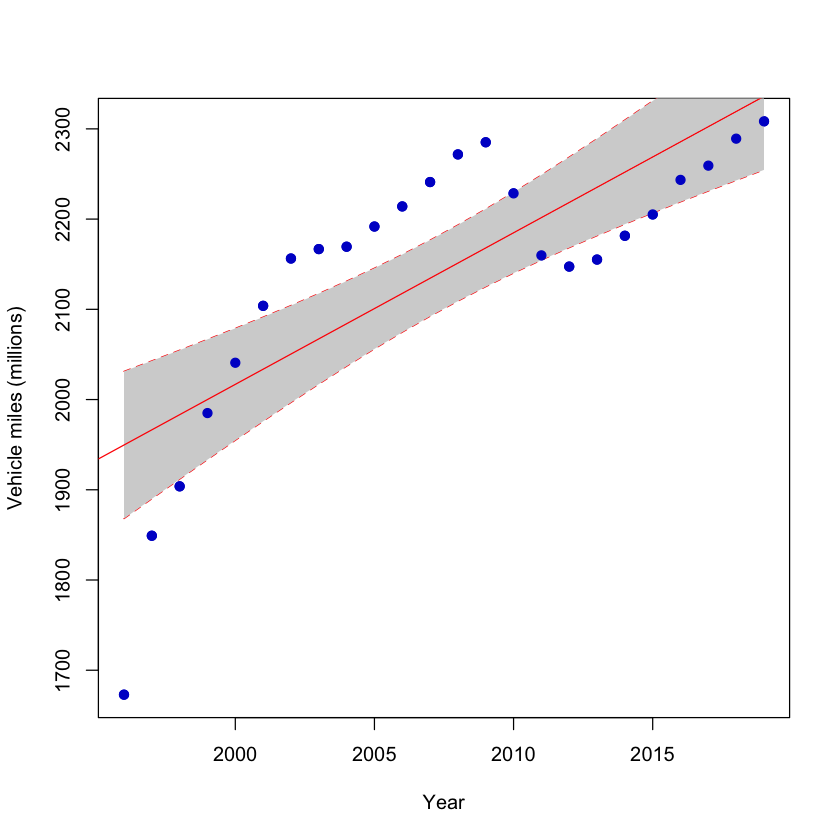

In [25]:
#plot(energy_consum_long$Energy_intensity_Btu_passenger_mile)

# Fit a linear model
lm_model <- lm(energy_consum_long_no_Covid$Vehicle_milesMill ~ energy_consum_long_no_Covid$Year)

# Create the plot
plot(energy_consum_long_no_Covid$Year, energy_consum_long_no_Covid$Vehicle_milesMill,
     xlab = "Year",
     ylab = "Vehicle miles (millions)",
     col = "blue3",
     pch = 19)

# Calculate confidence interval
conf_int <- predict(lm_model, interval = "confidence")

# Add confidence interval lines
lines(energy_consum_long_no_Covid$Year, conf_int[, "lwr"], col = "red", lty = 2)
lines(energy_consum_long_no_Covid$Year, conf_int[, "upr"], col = "red", lty = 2)

# Shade the area between confidence interval bounds
polygon(c(energy_consum_long_no_Covid$Year, rev(energy_consum_long_no_Covid$Year)),
        c(conf_int[, "lwr"], rev(conf_int[, "upr"])),
        col = "lightgray", border = NA)

# Add the trend line
abline(lm_model, col = "red")

# Add the points
points(energy_consum_long_no_Covid$Year, energy_consum_long_no_Covid$Vehicle_milesMill, col = "blue3", pch = 19)

The vehicle miles have been constantly increasing, which means that there have been more and more routes added over time. However, why has this not been enough to increase the demand of public transportation?

## DC Metro Scorecard
This part will focus on the DC_Metro_Scorecard data, which counts the reliability and efficiency of DC Metro from 2014 to 2016.

In [27]:
DC_metro <- read_excel("../../data/Raw_Data_project_Pub.Transport_5000/DC_Metro_Scorecard.xlsx", sheet="Sheet1")

# Select (or throwing away) unwanted columns for Data Exploration
DC_metro <- DC_metro%>% select (-"Crimes Target", -"Employee Injury Rate Target", -"Customer Injury Rate Target", -"Elevator Reliability", -"Elevator Reliability Target", -"Escalator Reliability Target",
-"Rail Fleet Reliability Target", -"Bus On-Time Performance Target", -"Bus Fleet Reliability Target", -"Escalator Reliability", -"Rail On-Time Performance Target")

# Rename Columns
colnames(DC_metro) <- c('Year','Month','Bus_on_time','Bus_fleet_reliability','Rail_fleet_reliability', 'Rail_on_time', 'Customer_injury_rate_per_1_Mill', 'Employee_injury_rate_per_200k_h', 'Crimes_per_1_Mill_passengers', 'Crimes_per_1_Mill_passengers')


Firstly, we are going to see wherther the year and the month have a significant effect on the values seen in our data. This will help us understand if it has become better over the years or if there are months that have effects on the outcomes of public transportation due to weather or other circumstances.

In [458]:
Bus_on_time <- DC_metro %>% select('Year', 'Month', 'Bus_on_time')

model <- aov(Bus_on_time ~ Year + Month, data = Bus_on_time)

# Summarize the ANOVA results with significance codes
summary_model <- summary(model)

# Print the ANOVA table with significance codes
print(anova(model, test = "F"))

Analysis of Variance Table

Response: Bus_on_time
          Df    Sum Sq    Mean Sq F value    Pr(>F)    
Year       2 0.0012562 0.00062809  7.6584 0.0031782 ** 
Month     12 0.0056355 0.00046963  5.7263 0.0002625 ***
Residuals 21 0.0017223 0.00008201                      
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Clearly year and month seem to have a significant effect on the buses being on time.

In [459]:
Bus_fleet_reliability <- DC_metro %>% select('Year', 'Month', 'Bus_fleet_reliability')

model <- aov(Bus_fleet_reliability ~ Year + Month, data = Bus_fleet_reliability)

# Summarize the ANOVA results with significance codes
summary_model <- summary(model)

# Print the ANOVA table with significance codes
print(anova(model, test = "F"))

Analysis of Variance Table

Response: Bus_fleet_reliability
          Df  Sum Sq Mean Sq F value   Pr(>F)   
Year       2 5604536 2802268  9.3323 0.001259 **
Month     12 9091418  757618  2.5231 0.030574 * 
Residuals 21 6305777  300275                    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Clearly year and month seem to have a significant effect on the bus fleet reliability (miles travelled before a breakdown).

In [460]:
Rail_fleet_reliability <- DC_metro %>% select('Year', 'Month', 'Rail_fleet_reliability')

model <- aov(Rail_fleet_reliability ~ Year + Month, data = Rail_fleet_reliability)

# Summarize the ANOVA results with significance codes
summary_model <- summary(model)

# Print the ANOVA table with significance codes
print(anova(model, test = "F"))

Analysis of Variance Table

Response: Rail_fleet_reliability
          Df     Sum Sq   Mean Sq F value  Pr(>F)  
Year       2  536503502 268251751  2.8728 0.07892 .
Month     12 2480920803 206743400  2.2141 0.05343 .
Residuals 21 1960928969  93377570                  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In this case, year and month don't seem to have a significant effect on rail transportation fleet reliability (miles travelled before a breakdown).

In [462]:
Rail_on_time <- DC_metro %>% select('Year', 'Month', 'Rail_on_time')

model <- aov(Rail_on_time ~ Year + Month, data = Rail_on_time)

# Summarize the ANOVA results with significance codes
summary_model <- summary(model)

# Print the ANOVA table with significance codes
print(anova(model, test = "F"))

Analysis of Variance Table

Response: Rail_on_time
          Df   Sum Sq   Mean Sq F value    Pr(>F)    
Year       2 0.060978 0.0304888 52.2126 7.084e-09 ***
Month     12 0.020835 0.0017363  2.9734   0.01397 *  
Residuals 21 0.012263 0.0005839                      
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Clearly year and month seem to have a significant effect on the rail transportation being on time.

In [466]:
Customer_injury_rate_per_1_Mill <- DC_metro %>% select('Year', 'Month', 'Customer_injury_rate_per_1_Mill')

model <- aov(Customer_injury_rate_per_1_Mill ~ Year + Month, data = Customer_injury_rate_per_1_Mill)

# Summarize the ANOVA results with significance codes
summary_model <- summary(model)

# Print the ANOVA table with significance codes
print(anova(model, test = "F"))

Analysis of Variance Table

Response: Customer_injury_rate_per_1_Mill
          Df  Sum Sq Mean Sq F value  Pr(>F)  
Year       2  0.1121 0.05606  0.1770 0.83903  
Month     12 11.8039 0.98366  3.1056 0.01119 *
Residuals 21  6.6515 0.31674                  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Only the month seems to have a significant effect on the customer injury rate (which is expected due to weather). However, if year does not, have we taken any necessary actions to improve the security on public transportation?

In [467]:
Employee_injury_rate_per_200k_h <- DC_metro %>% select('Year', 'Month', 'Employee_injury_rate_per_200k_h')

model <- aov(Employee_injury_rate_per_200k_h ~ Year + Month, data = Employee_injury_rate_per_200k_h)

# Summarize the ANOVA results with significance codes
summary_model <- summary(model)

# Print the ANOVA table with significance codes
print(anova(model, test = "F"))

Analysis of Variance Table

Response: Employee_injury_rate_per_200k_h
          Df Sum Sq Mean Sq F value  Pr(>F)   
Year       2 11.822  5.9109  9.0165 0.00149 **
Month     12 12.759  1.0632  1.6218 0.16025   
Residuals 21 13.767  0.6556                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In this case as year has a significant effect on employee injury rates and months do not, we can assume that some actions have been taken during the years.

In [468]:
Crimes_per_1_Mill_passengers <- DC_metro %>% select('Year', 'Month', 'Crimes_per_1_Mill_passengers')

model <- aov(Crimes_per_1_Mill_passengers ~ Year + Month, data = Crimes_per_1_Mill_passengers)

# Summarize the ANOVA results with significance codes
summary_model <- summary(model)

# Print the ANOVA table with significance codes
print(anova(model, test = "F"))

Analysis of Variance Table

Response: Crimes_per_1_Mill_passengers
          Df  Sum Sq Mean Sq F value  Pr(>F)  
Year       1  0.2313 0.23133  0.6465 0.44209  
Month     12 14.6777 1.22314  3.4182 0.03656 *
Residuals  9  3.2205 0.35783                  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Only months seem to have a significant effect on crime rates produced on public transportation. We could use this information to decide what months of the year we should increase security and question if this effect is due to holidays or other important events.

In [ ]:
# preparing data to set a column in Date format in order to properly graph it
DC_metro <- DC_metro %>%
      mutate_at("Year", str_replace, "CY ", "")
head(DC_metro)

DC_metro$Year <- as.numeric(DC_metro$Year)

DC_metro <- DC_metro %>%
      mutate_at("Month", str_replace, "Jan", "01")
DC_metro <- DC_metro %>%
      mutate_at("Month", str_replace, "Feb", "02")
DC_metro <- DC_metro %>%
      mutate_at("Month", str_replace, "Mar", "03")
DC_metro <- DC_metro %>%
      mutate_at("Month", str_replace, "Apr", "04")
DC_metro <- DC_metro %>%
      mutate_at("Month", str_replace, "May", "05")
DC_metro <- DC_metro %>%
      mutate_at("Month", str_replace, "Jun", "06")
DC_metro <- DC_metro %>%
      mutate_at("Month", str_replace, "Jul", "07")
DC_metro <- DC_metro %>%
      mutate_at("Month", str_replace, "Aug", "08")
DC_metro <- DC_metro %>%
      mutate_at("Month", str_replace, "Sep", "09")
DC_metro <- DC_metro %>%
      mutate_at("Month", str_replace, "Oct", "10")
DC_metro <- DC_metro %>%
      mutate_at("Month", str_replace, "Nov", "11")
DC_metro <- DC_metro %>%
      mutate_at("Month", str_replace, "Dec", "12")

DC_metro <- DC_metro[order(DC_metro$Year, DC_metro$Month), ]
# Drop YTD rows for month
DC_metro <- subset(DC_metro, DC_metro$Month!='YTD')
head(DC_metro)

library(zoo)

DC_metro$Date <- as.yearmon(paste(DC_metro$Month, DC_metro$Year, sep = " "), format = "%m %Y")

`geom_smooth()` using formula 'y ~ x'



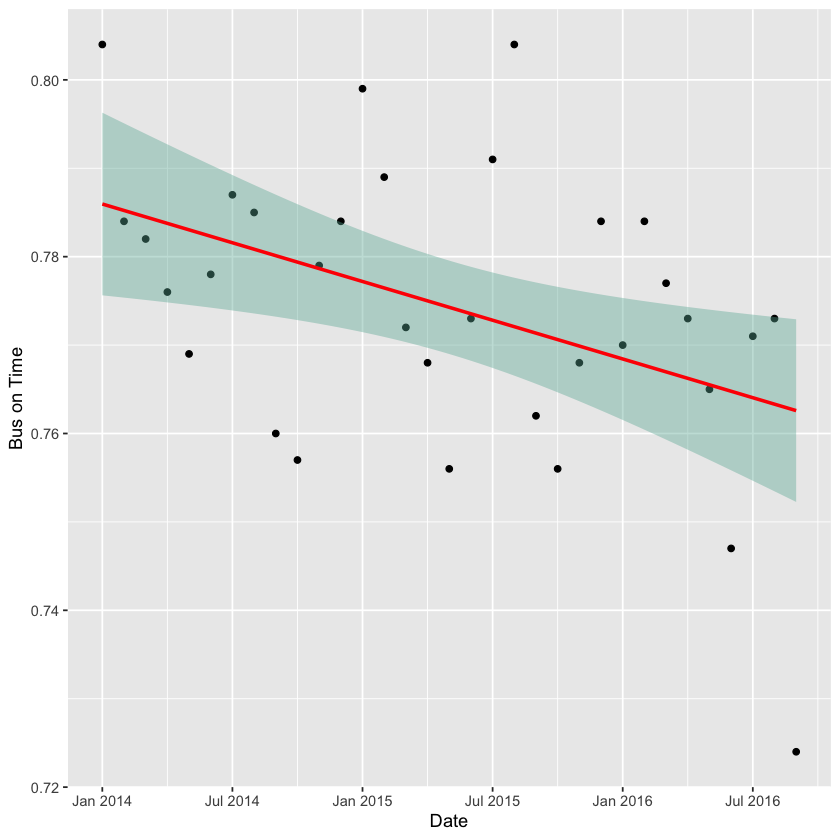

In [30]:
options(warn = -1) 
ggplot(DC_metro, aes(x=DC_metro$Date, y=DC_metro$Bus_on_time)) +
  geom_point() +
  geom_smooth(method=lm , color="red", fill="#69b3a2", se=TRUE) +
  xlab("Date") +  # Add x-axis label
  ylab("Bus on Time")  # Add y-axis label

While the spread of the points is very wide, it is concerning to see a trend in which the Buses seem to be more and more delayed over time. That means that we are not taking the necessary steps to improve it.

`geom_smooth()` using formula 'y ~ x'



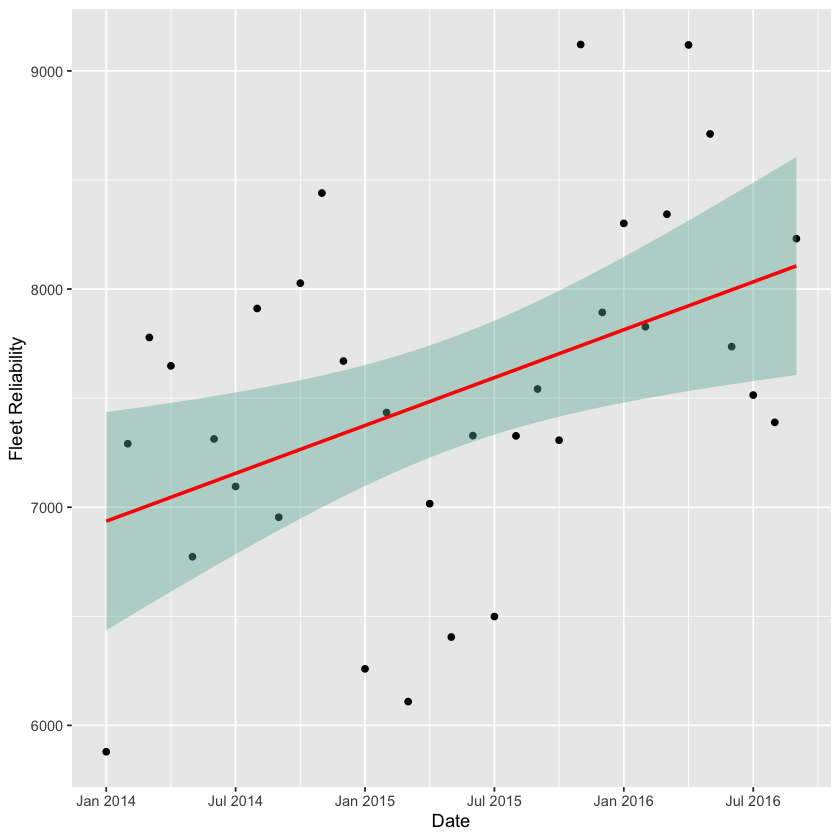

In [32]:
options(warn = -1) 
ggplot(DC_metro, aes(x=DC_metro$Date, y=DC_metro$Bus_fleet_reliability)) +
  geom_point() +
  geom_smooth(method=lm , color="red", fill="#69b3a2", se=TRUE) +
  xlab("Date") +  # Add x-axis label
  ylab("Fleet Reliability")  # Add y-axis label

Fleet reliability has improved over time (even though the spread of the data is too wide). That is probably due to vehicle improvements.

`geom_smooth()` using formula 'y ~ x'



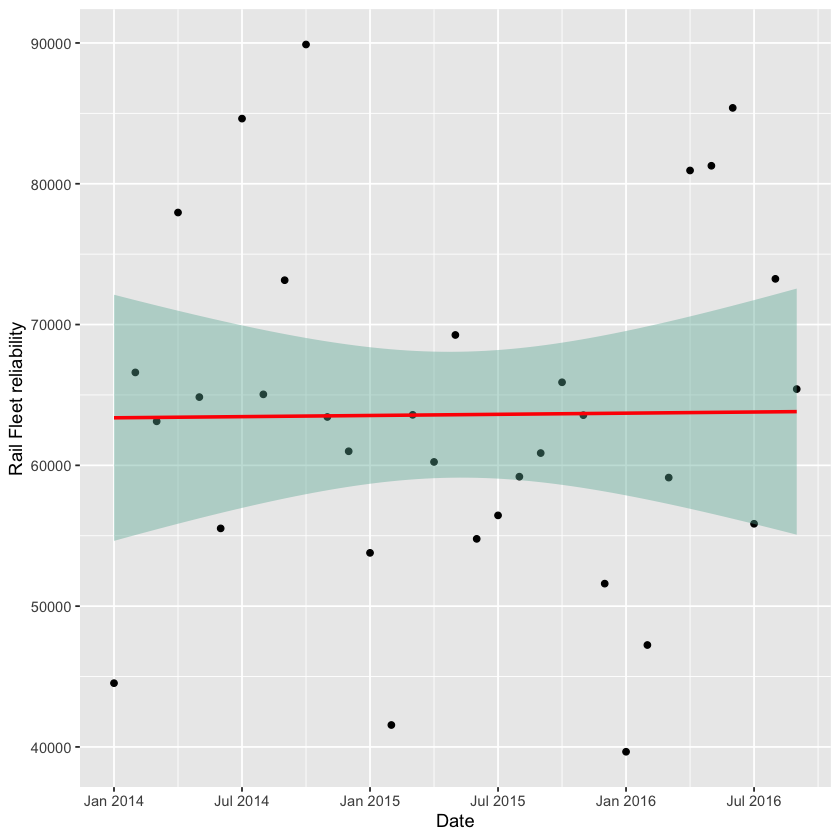

In [34]:
options(warn = -1) 
ggplot(DC_metro, aes(x=DC_metro$Date, y=DC_metro$Rail_fleet_reliability)) +
  geom_point() +
  geom_smooth(method=lm , color="red", fill="#69b3a2", se=TRUE) +
  xlab("Date") +  # Add x-axis label
  ylab("Rail Fleet reliability")  # Add y-axis label

There seems to not be a clear improvement on the fleet reliability of rail transportation over this period of time.

`geom_smooth()` using formula 'y ~ x'



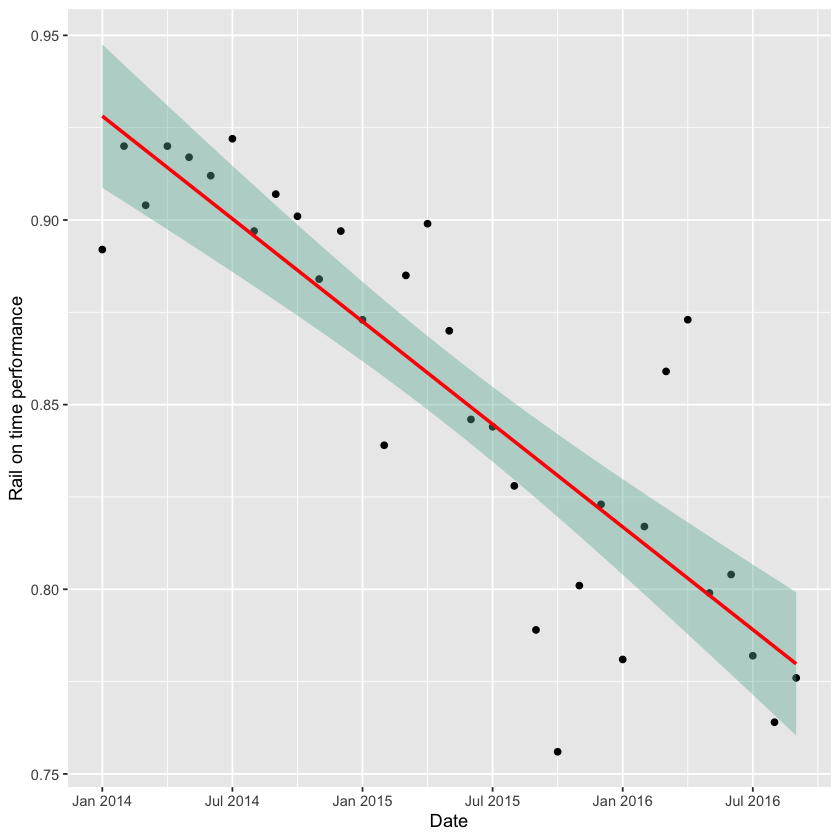

In [36]:
options(warn = -1) 
ggplot(DC_metro, aes(x=DC_metro$Date, y=DC_metro$Rail_on_time)) +
  geom_point() +
  geom_smooth(method=lm , color="red", fill="#69b3a2", se=TRUE) +
  xlab("Date") +  # Add x-axis label
  ylab("Rail on time performance")  # Add y-axis label

Rail transportation seems to clearly have been getting worse over time. This problem is concerning and should be tackled as soon as possible. Is it due to safety reasons, investment problems, or poor planification?

`geom_smooth()` using formula 'y ~ x'



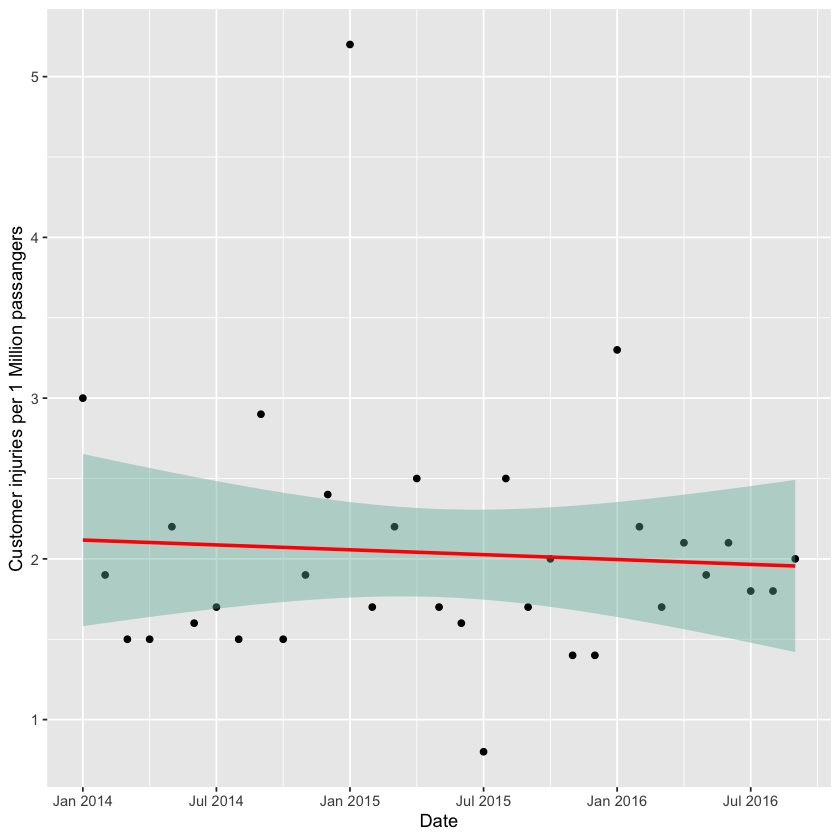

In [37]:
options(warn = -1) 
ggplot(DC_metro, aes(x=DC_metro$Date, y=DC_metro$Customer_injury_rate_per_1_Mill)) +
  geom_point() +
  geom_smooth(method=lm , color="red", fill="#69b3a2", se=TRUE) +
  xlab("Date") +  # Add x-axis label
  ylab("Customer injuries per 1 Million passangers")  # Add y-axis label

Customer injuries seem to have been stable overtime (with a couple of outliers that could be interesting to look for).

`geom_smooth()` using formula 'y ~ x'



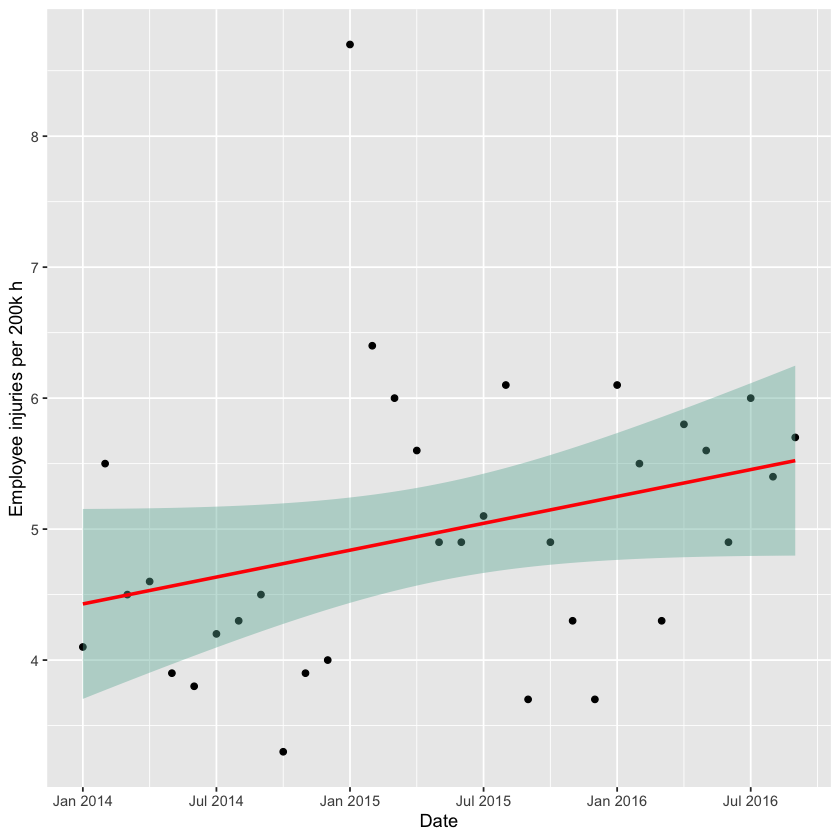

In [40]:
options(warn = -1) 
ggplot(DC_metro, aes(x=DC_metro$Date, y=DC_metro$Employee_injury_rate_per_200k_h)) +
  geom_point() +
  geom_smooth(method=lm , color="red", fill="#69b3a2", se=TRUE) +
  xlab("Date") +  # Add x-axis label
  ylab("Employee injuries per 200k h")  # Add y-axis label

The employee injuries have been increasing over time. This means that if the trend keeps following this pattern, we should probably invest more in safety and take some more precautions for the employees.

`geom_smooth()` using formula 'y ~ x'



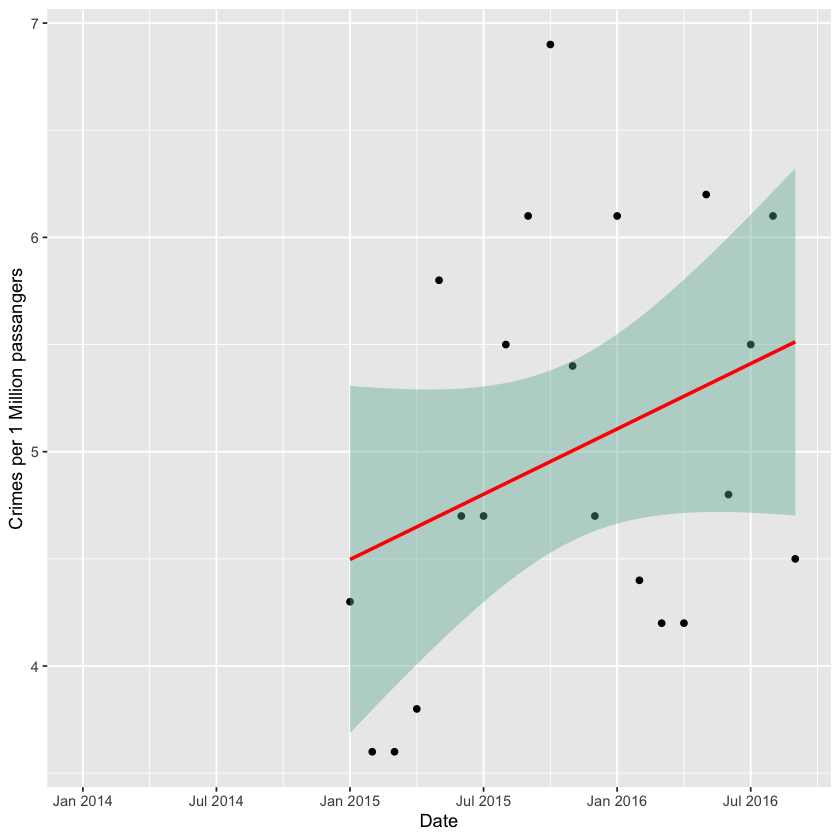

In [39]:
options(warn = -1) 
ggplot(DC_metro, aes(x=DC_metro$Date, y=DC_metro$Crimes_per_1_Mill_passengers)) +
  geom_point() +
  geom_smooth(method=lm , color="red", fill="#69b3a2", se=TRUE) +
  xlab("Date") +  # Add x-axis label
  ylab("Crimes per 1 Million passangers")  # Add y-axis label

The crime rates have been increasing over time. This means that if the trend keeps following this pattern, we should probably invest in more security on public transportation.

## Text Data
In order to see what what are the most important concerns regarding public transportation to the users, we are going top explore what people mention the most in their reddits about public transportation through a word cloud. 

In [ ]:
import re
import spacy.lang.en.stop_words as stopwords
import spacy
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.feature_extraction.text import CountVectorizer

# read in the data
df=pd.read_json("../../data/Raw_Data_project_Pub.Transport_5000/Reddit_sentiment_data/sentiment_results.json")
print(df.shape)
print(df.columns)

# throw away all empty strings of text from df along with their url and sentiment_score
df = df[df.text != '']
print(df.shape)
print(df.columns)

texts = []
y = []
#https://spacy.io/usage/models


parser = spacy.load('en_core_web_sm')
stop_words = stopwords.STOP_WORDS


# Iterate over rows
for i in range(df.shape[0]):
    # QUICKLY CLEAN TEXT
    keep = "abcdefghijklmnopqrstuvwxyz "
    replace = ".,!;"
    tmp = ""
    text_value = df["text"].iloc[i]  # Accessing the "text" column using .iloc


    text_value = re.sub('[^a-zA-Z ]+', '', text_value.replace("<br />", "").lower())
    text_value = parser(text_value)
    tokens = [token.lower_ for token in text_value]
    #tokens = [token for token in text_value if token not in stop_words]
    tokens = [token.lemma_ for token in text_value if token not in stop_words]


    tmp = " ".join(tokens)
    texts.append(tmp)
wordcloud_text = " ".join(texts)


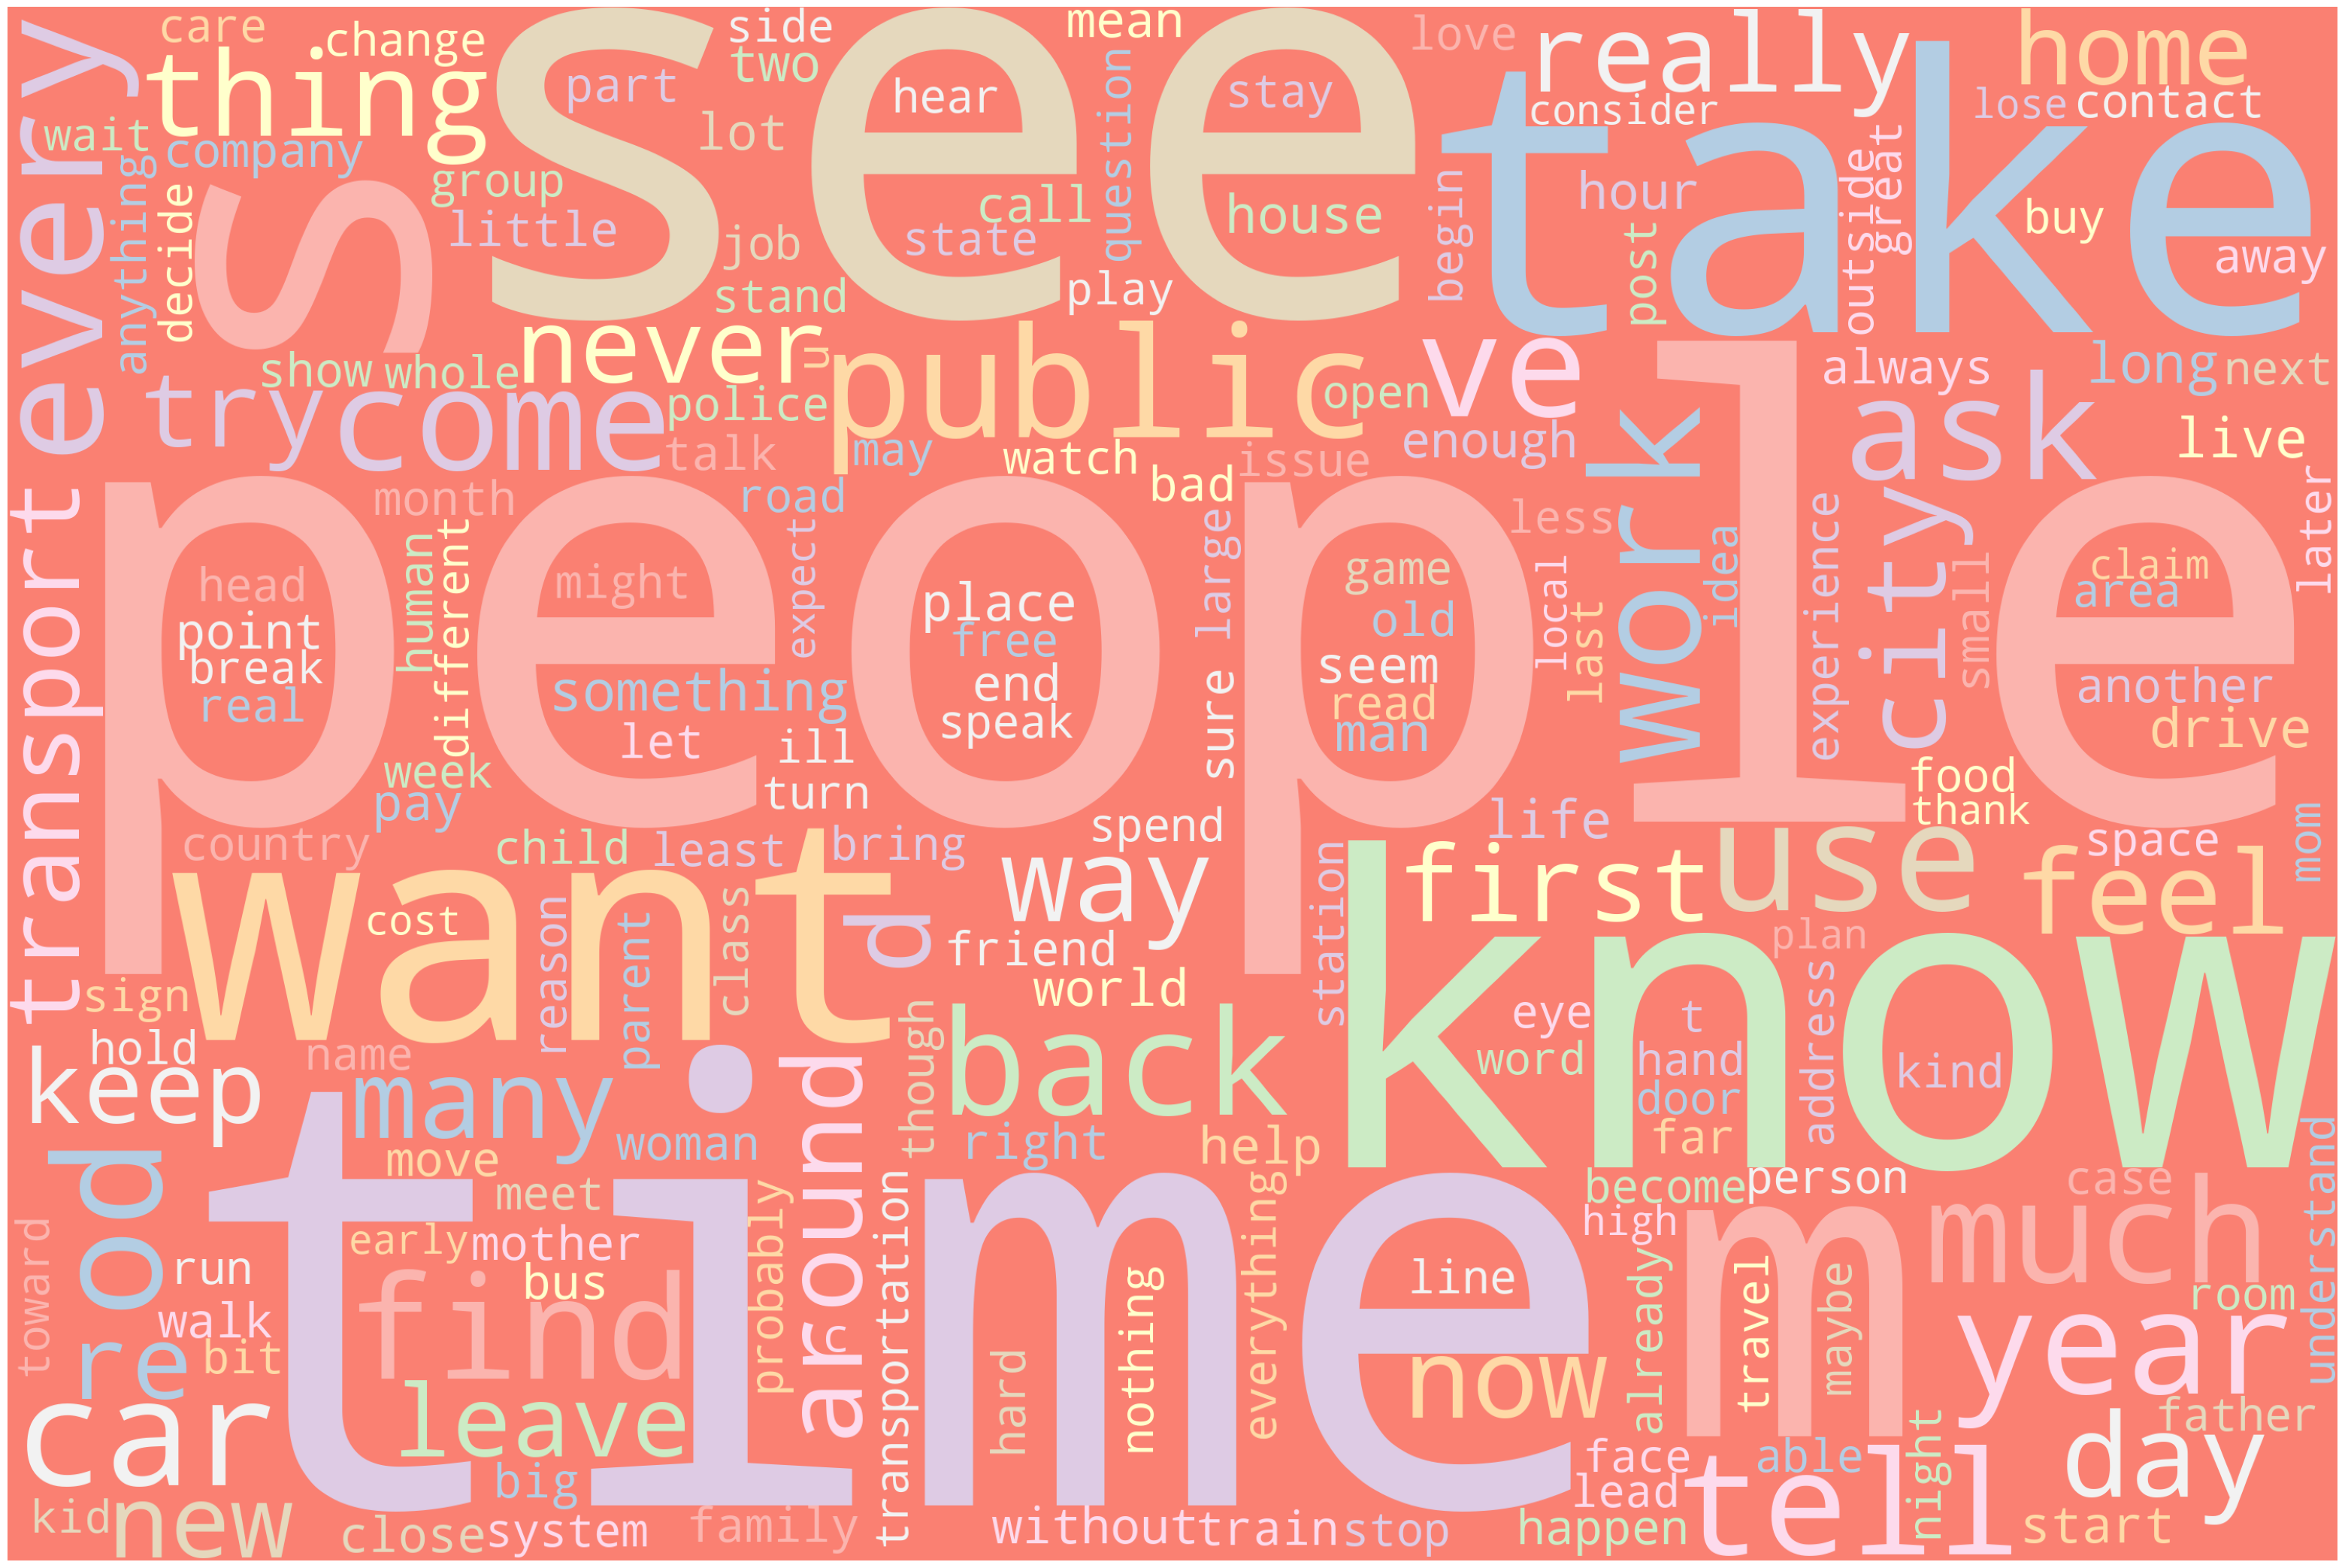

In [7]:
def generate_word_cloud(my_text):
    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.pyplot as plt

    def plot_cloud(wordcloud):
        # Set figure size
        plt.figure(figsize=(40, 30))
        # Display image
        plt.imshow(wordcloud) 
        # No axis details
        plt.axis("off");

    # Generate word cloud
    wordcloud = WordCloud(
        width = 3000,
        height = 2000, 
        random_state=1, 
        background_color='salmon', 
        colormap='Pastel1', 
        collocations=False,
        stopwords = STOPWORDS).generate(my_text)
    plot_cloud(wordcloud)
    plt.show()

worldcloud_text = " ".join(texts)

# Words to remove
words_to_remove = ["one", "go", "even", "give", "will", "need", "say", "well", "still", "make", "think", "look", "etc", "actually", "yet", "put"]

# Remove specified words from the result
for word in words_to_remove:
    wordcloud_text = wordcloud_text.replace(word, "")



generate_word_cloud(wordcloud_text)

From this world loud, we can see what topics are the most talked about by people regarding publioc transportation. This can help us see what matters to them the most and focus on these topics.